Librerias a utilizar

In [7]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

Leemos el dataset

In [8]:
# Cargamos el dataset, el cual está comprimido en un .zip
ruta_zip = '../data/RepoRT_classified_CCinformation.zip'
nombre_tsv = 'RepoRT_classified_CCinformation.tsv'

with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
    with archivo_zip.open(nombre_tsv) as archivo_tsv:
        dataset = pd.read_csv(archivo_tsv, sep='\t')


C:\Users\cmora\AppData\Local\Temp\ipykernel_41476\496839114.py:7: DtypeWarning: Columns (1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(archivo_tsv, sep='\t')


Función temporar para guardar el tipo de datos en .csv

In [9]:
# Función para guardar el tipo de datos en un archivo.csv
def guardar_tipo_de_datos(dataset, nombre_archivo='./data/tipos_datos.csv'):
    nombres_columnas = []
    tipos_datos = []

    for columna in dataset.columns:
        tipos_unicos = {type(dato).__name__ for dato in dataset[columna] if pd.notnull(dato)}
        nombres_columnas.append(columna)
        tipos_datos.append(', '.join(tipos_unicos))

    df_tipos = pd.DataFrame({'Nombre': nombres_columnas, 'Tipos': tipos_datos})

    df_tipos.to_csv(nombre_archivo, index=False)

Tratamiento de los tipos de datos

In [10]:
# Ponemos todos los datos de las columnas del mismo tipo
dataset['name'] = dataset['name'].astype('str')
dataset['comment'] = dataset['comment'].astype('str')

Gráficas sobre cuantos RT's hay según el nivel y su tipo. Realizamos estas gráficas para poder tomar una decisión sobre que nivel realizar el scoring.

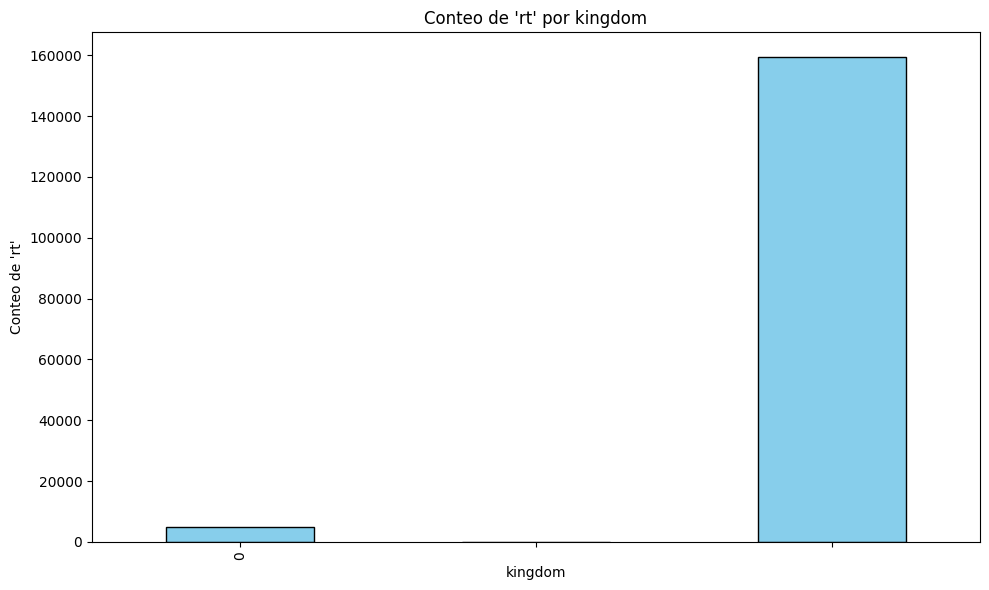

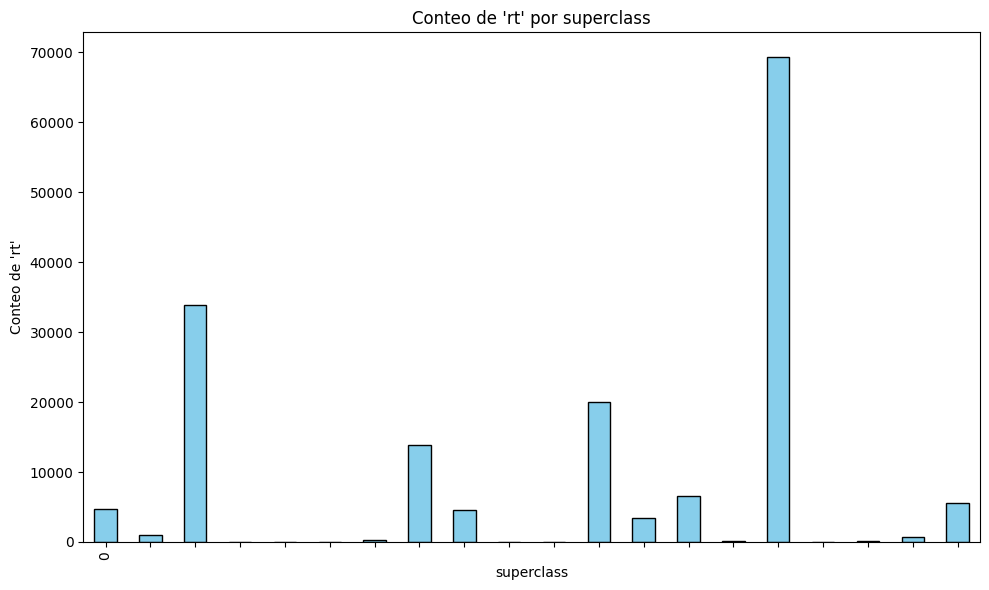

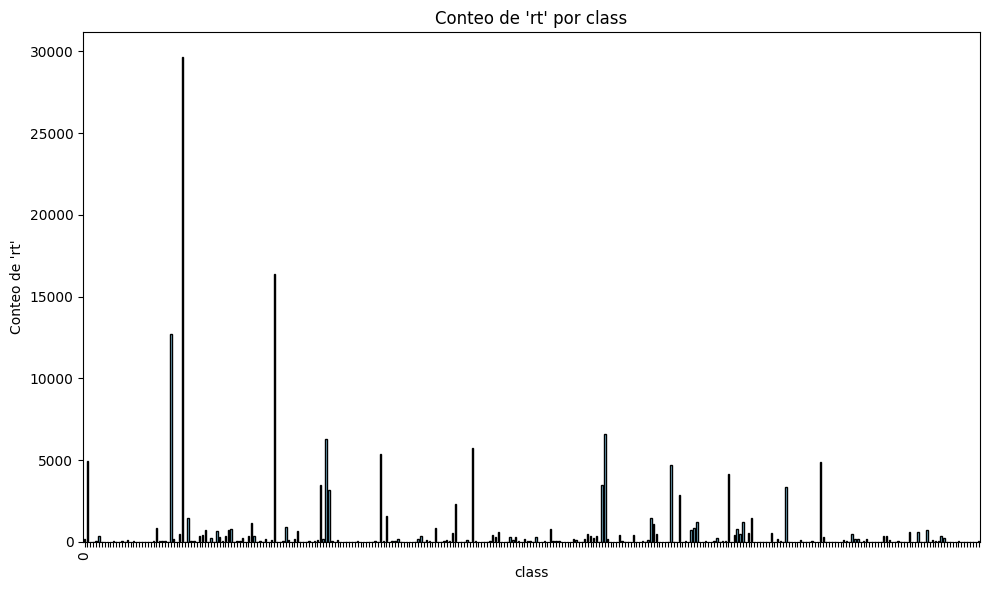

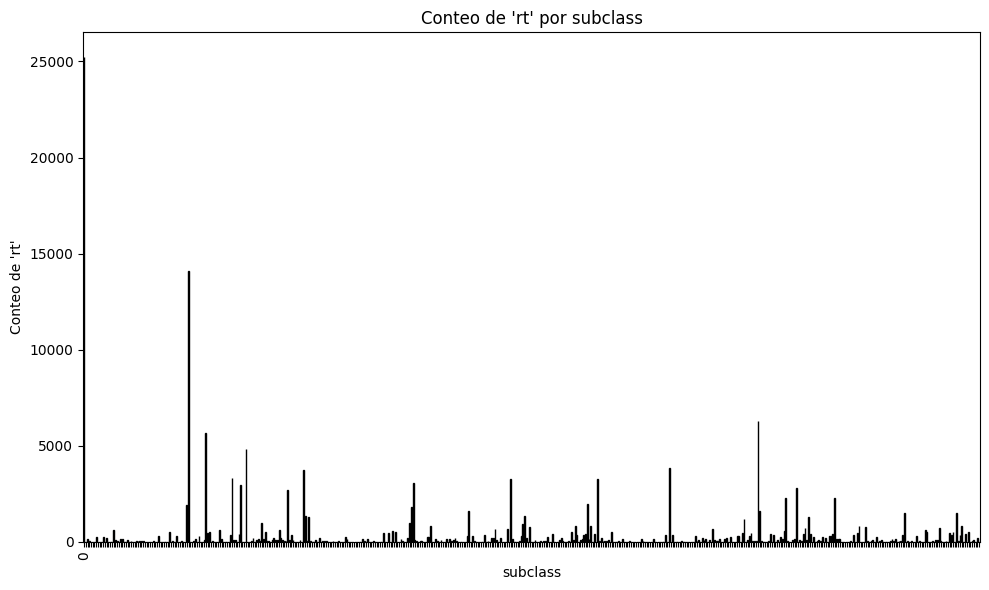

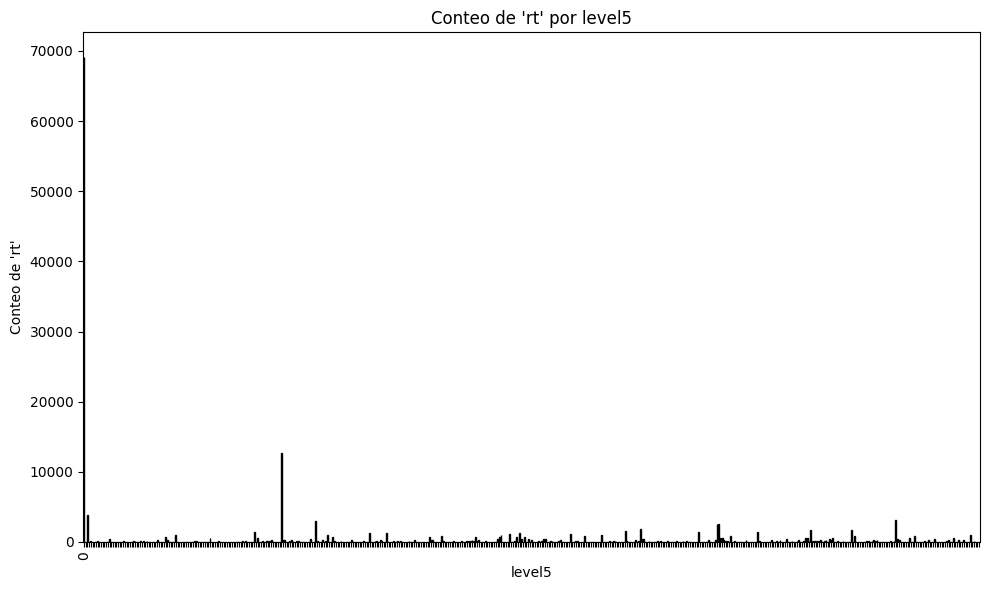

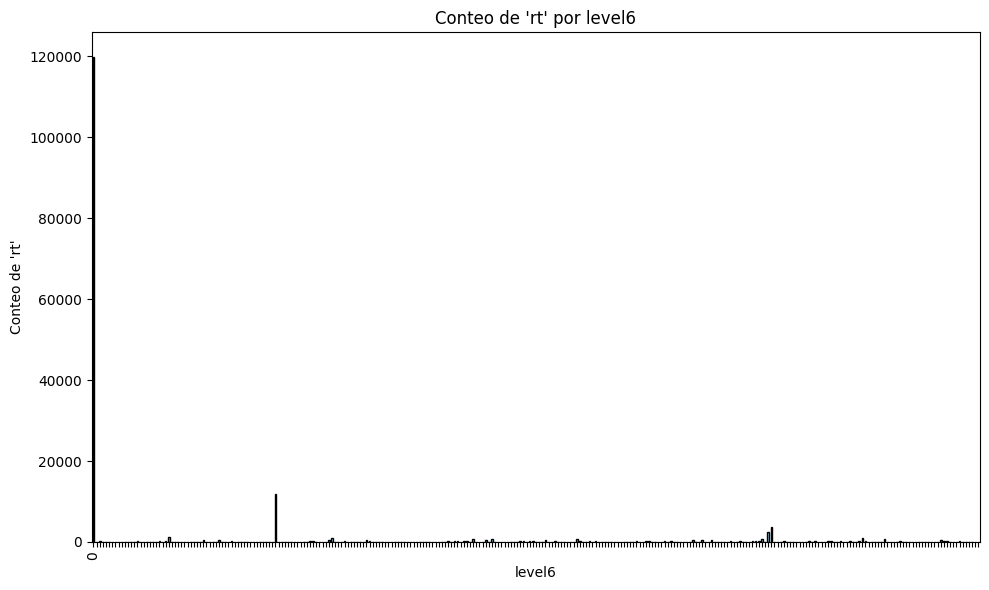

In [11]:
familias = ["kingdom", "superclass", "class", "subclass", "level5", "level6"]
rt_counts = {}
for familia in familias:
    grupo = dataset.groupby(f'classyfire.{familia}')['rt']

    rt_counts[familia] = grupo.count()

for familia, counts in rt_counts.items():
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Conteo de 'rt' por {familia}")
    plt.xlabel(familia)
    plt.ylabel("Conteo de 'rt'")

    # Configurar etiquetas en el eje x, solo mostrar '0' para la primera posición
    etiquetas = [''] * len(counts)  # Crear etiquetas vacías
    etiquetas[0] = '0'              # Asignar '0' a la primera etiqueta
    plt.xticks(ticks=range(len(counts)), labels=etiquetas)

    plt.tight_layout()
    plt.show()


Analizamos las métricas a utilizar:

* Reproducibilidad del Tiempo de Retención
* Promedio de RT entre una Familia de Metabolitos
* Factor de selectividad (alpha)
* Resolución (Rs)
* Eficiencia de la columna (N)


Obtenemos los rts para una familia.

In [12]:
familia = "Flavonoids (CHEMONTID:0000334)"
nivel = "classyfire.class"
configuracion = {
    "column.name" : "",	
    "column.length"	: "",
    "column.ups" : "",
    "column.particle.size"	: "",
    "column.temperature" : "",
    "column.flowrate" : "",	
    "Eluyente 1" : "",
    "Eluyente 2" : "",
    "proporcion por fase" : [()]
}

In [13]:
import json
import os

def leer_configuracion_json(ruta_json):
    
    # Verificar si el archivo existe
    if not os.path.exists(ruta_json):
        raise FileNotFoundError(f"El archivo no se encuentra en la ruta: {ruta_json}")
    
    # Leer el archivo JSON
    with open(ruta_json, 'r') as file:
        try:
            configuracion = json.load(file)
        except json.JSONDecodeError:
            raise ValueError("Error al decodificar el archivo JSON. Asegúrate de que tenga un formato válido.")

    return configuracion

In [14]:
# Ruta al archivo de configuración JSON
ruta_configuracion = '../data/json/datosprueba.json'

# Lee la configuración desde el JSON
data = leer_configuracion_json(ruta_configuracion)

print(f'{data["sample"]["family"]}')

Flavonoids (CHEMONTID:0000334)


In [15]:
def prediccion_rts(dataset, familia, nivel, configuracion):
    # Filtrar por familia y nivel
    select = dataset[dataset[nivel] == familia]

    # Filtrar por las configuraciones especificadas
    for key, value in configuracion.items():
        if key in select.columns:
            select = select[select[key] == value]

    return select['rt']



In [16]:
def filtrado_datos(dataset, familia, nivel, configuracion):
    # Filtrar por familia y nivel
    select = dataset[dataset[nivel] == familia]

    # Filtrar por las configuraciones especificadas
    for key, value in configuracion.items():
        if key in select.columns:
            select = select[select[key] == value]

    return select

In [17]:
# Ruta al archivo de configuración JSON
ruta_configuracion = '../data/json/datosprueba.json'

# Lee la configuración desde el JSON
data = leer_configuracion_json(ruta_configuracion)

print(f'{data["sample"]["family"]}')

Flavonoids (CHEMONTID:0000334)


In [18]:
familia = data['sample']['family']
nivel = data['sample']['level']
configuracion = data['configuration']
rts = prediccion_rts(dataset, familia, nivel, configuracion)

print(rts)

0     12.070000
1     15.990000
2      8.675000
10    15.550000
14    21.130000
15    20.530000
16    20.590000
18    20.285000
19    20.490000
20    19.730000
22    20.460000
23    21.040000
24    19.530000
28    20.210000
31     9.660000
33    17.380000
34    19.910000
35    20.370000
36    20.110000
37    20.000000
38    20.000000
40    16.820000
43    20.590000
44    21.960000
51    19.743276
52    12.730000
54    17.820000
Name: rt, dtype: float64


Reproducibilidad del Tiempo de Retención.
$$
\text{CVRT} = \left( \frac{\text{Desviación estándar del RT}}{\text{Media del RT}} \right) \times 100
$$


In [19]:
def cvrt(rts):
    # Calcular desviación estándar y media, ignorando valores NaN
    std = rts.std(skipna=True)
    mean = rts.mean(skipna=True)

    return (std / mean) * 100

Como valorar esta métrica:

* Muy Bajo (CV < 5%):

Indica una excelente repetibilidad en los tiempos de retención. Este nivel de precisión es ideal en análisis de rutina con una instrumentación bien controlada y en estudios donde se requieren resultados altamente repetibles.

* Moderado (5% ≤ CV ≤ 15%):

Un CV en este rango es generalmente aceptable para muchas aplicaciones analíticas. Esto indica buena consistencia en los tiempos de retención con una ligera variabilidad.

* Alto (15% < CV < 30%):

Puede ser aceptable para algunas muestras complejas o para métodos de exploración, aunque este nivel de variabilidad puede afectar la precisión en la identificación de compuestos. Esto podría ser una señal de que se requiere un mayor control de variables experimentales.

* Muy Alto (CV > 30%):

Un CV superior a 30% generalmente se considera inaceptable para la mayoría de los análisis cromatográficos, especialmente si el objetivo es cuantitativo. Esto sugiere alta variabilidad en el sistema, presencia de compuestos con elución muy variable o posibles problemas experimentales, como picos mal definidos o interferencias.

In [20]:
print(cvrt(rts))

19.68096808068989


Factor de selectividad.

$$
\alpha = \frac{t_{R,A} - t_0}{t_{R,B} - t_0}
$$

* RTa: Tiempo de retención del metabolito A.
* RTb: Tiempo de retención del metabolito B.
* 𝑡0: Tiempo de retención del soluto no retenido (tiempo muerto).
$$
\text{Tiempo muerto} = \frac{\text{longitud de la columna}}{\text{Flowrate}}
$$

α > 1: Indica que el compuesto más retenido (es decir, el que tiene el tiempo de retención más largo) se eluye más lentamente que el compuesto menos retenido. Esto sugiere que hay una buena separación entre los dos compuestos.

α = 1: Indica que ambos compuestos se eluyen al mismo tiempo, lo que significa que no hay separación.

α < 1: Esto es raro y generalmente indica que el sistema no está funcionando correctamente, ya que el compuesto más retenido se eluye más rápidamente que el menos retenido.


Un α alto (por ejemplo, α > 1.5) generalmente se considera favorable y sugiere que el método cromatográfico es eficiente para separar los compuestos. Por ejemplo, α entre 1.5 y 2 se considera una separación buena, mientras que α > 2 es excelente.

Un α bajo puede indicar problemas en la separación, lo que puede requerir ajustes en las condiciones de la cromatografía, como cambios en la fase móvil, temperatura, o tipo de columna.

In [21]:


def alpha_list(rts: pd.Series, length: float, flowrate: float) -> float:
    t0 = length / flowrate
    suma = 0
    n = len(rts)

    # Iterate from 0 to n-1 to calculate alpha values
    for i in range(n - 1):
        alpha_value = (rts.iloc[i] - t0) / (rts.iloc[i + 1] - t0)
        suma += alpha_value 

    # Return the average of alpha values
    return suma / (n - 1) if n > 1 else 0  # Handle case if n is 1 or less


In [22]:
def alpha(rta, rtb, t0):
    return (rta - t0) / (rtb - t0)

In [23]:
resultado = alpha_list(rts, data['configuration']['column.length'], data['configuration']['column.flowrate'])

print(resultado)


1.0004555376902553


In [41]:
for i, j in data.items():
    print(f'key: {i}\ndata: {j}\n\n')

filtered_columns = dataset.loc[:, dataset.columns.str.contains(r'^t \d{1,2}$')]
print(filtered_columns.columns)
print(filtered_columns)

key: sample
data: {'family': 'Flavonoids (CHEMONTID:0000334)', 'level': 'classyfire.class'}


key: configuration
data: {'column.name': 'Waters ACQUITY UPLC HSS T3', 'column.length': 150.0, 'column.ups': 'column.usp.code_L1', 'column.particle.size': 1.8, 'column.temperature': 40.0, 'column.flowrate': 0.28, 'eluent_1': 'h2o', 'eluent_2': 'meoh', 'proporcion por fase': [{'t0': {'eluent_1': 100, 'eluent_2': 0}}]}


Index(['t 0', 't 1', 't 2', 't 3', 't 4', 't 5', 't 6', 't 7', 't 8', 't 9',
       't 10', 't 11', 't 12', 't 13', 't 14', 't 15', 't 16', 't 17'],
      dtype='object')
        t 0  t 1  t 2   t 3   t 4   t 5   t 6   t 7  t 8  t 9  t 10  t 11  \
0       0.0  1.0  3.0  18.0  21.0  25.5  25.6  28.0  0.0  0.0   0.0   0.0   
1       0.0  1.0  3.0  18.0  21.0  25.5  25.6  28.0  0.0  0.0   0.0   0.0   
2       0.0  1.0  3.0  18.0  21.0  25.5  25.6  28.0  0.0  0.0   0.0   0.0   
3       0.0  1.0  3.0  18.0  21.0  25.5  25.6  28.0  0.0  0.0   0.0   0.0   
4       0.0  1.0  3.0  18.0  

In [ ]:

plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f"Conteo de datos por tiempo")
plt.xlabel(filtered_columns.columns)
plt.ylabel("Conteo de datos que no son 0")

# Configurar etiquetas en el eje x, solo mostrar '0' para la primera posición
etiquetas = [''] * len(counts)  # Crear etiquetas vacías
etiquetas[0] = '0'              # Asignar '0' a la primera etiqueta
plt.xticks(ticks=range(len(counts)), labels=etiquetas)

plt.tight_layout()
plt.show()


Resolución (Rs).

$$
R_s = \frac{2(t_{R,B} - t_{R,A})}{w_A + w_B}
$$


In [24]:
def rs(rt1, rt2, w1, w2):
    return (2 * (rt2-rt1)) / w1 + w2

In [69]:

dataset['W1'] = dataset.filter(like='eluent.1').sum(axis=1)

# Sumar todas las columnas que contengan 'eluent.2'
dataset['W2'] = dataset.filter(like='eluent.2').sum(axis=1)

# Mostrar el DataFrame con W1 y W2
print(dataset[['W1', 'W2']])


            W1      W2
0       1374.8  1074.8
1       1374.8  1074.8
2       1374.8  1074.8
3       1374.8  1074.8
4       1374.8  1074.8
...        ...     ...
164341   996.2   820.6
164342   996.2   820.6
164343   996.2   820.6
164344   996.2   820.6
164345   996.2   820.6

[164346 rows x 2 columns]


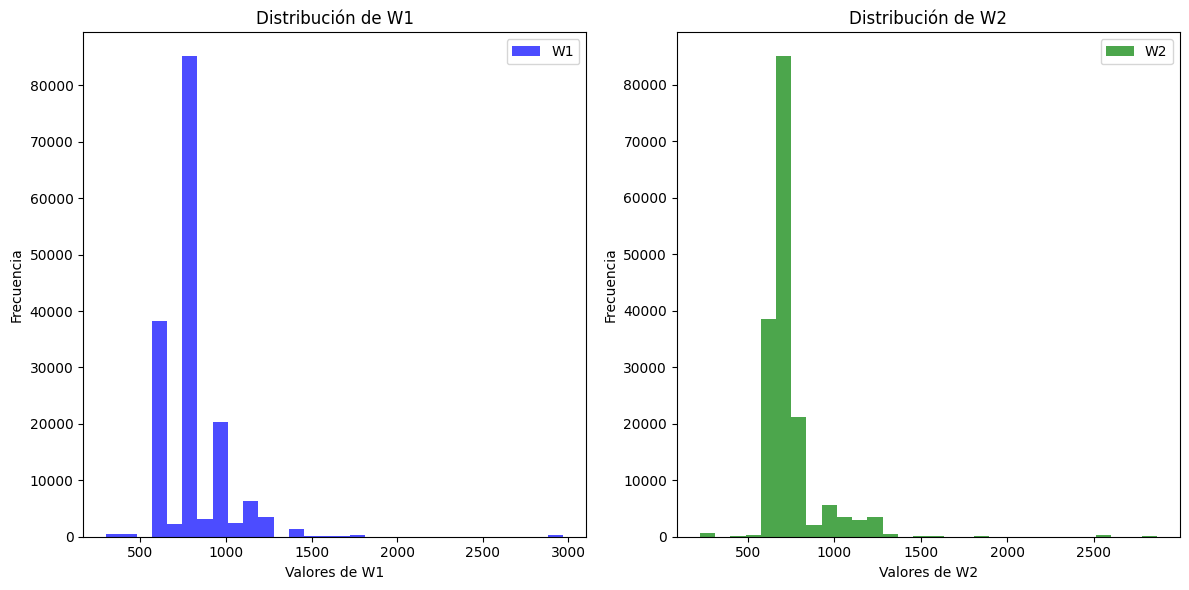

In [71]:
# Histograma de W1 y W2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(dataset['W1'], bins=30, alpha=0.7, color='blue', label='W1')
plt.title('Distribución de W1')
plt.xlabel('Valores de W1')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(dataset['W2'], bins=30, alpha=0.7, color='green', label='W2')
plt.title('Distribución de W2')
plt.xlabel('Valores de W2')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

Eficiencia de la columna (N).

$$
N = \frac{16(t_R)^2}{w^2}
$$


In [19]:
def n(rt, w):
    return (16*(rt*rt)) / w*w

Promedio de RT entre una Familia de Metabolitos.

$$
\text{RT promedio} = \frac{\sum_{i=1}^{n} t_{R,i}}{n}
$$

* RT: Tiempos de retención de los metabolitos.
* n: Número total de metabolitos en la familia.


In [66]:
def mean(rts):
    return rts.sum()/rts.count()

In [68]:
print(mean(rts))

18.27308429111111
